# Bag of Words Meets Bags of Popcorn

[Kaggle Chanllenge](https://www.kaggle.com/c/word2vec-nlp-tutorial)
Use Google's Word2Vec for movie reviews

Deadline: 2019/01/05

In [1]:
import numpy as np
import pandas as pd
import keras

import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

## Import Cleaned Data

In [3]:
train = pd.read_csv( "Data/Word2Vec_clean_labeledTrainData.csv", index_col=0 )

unlabeled_train = pd.read_csv( "Data/Word2Vec_clean_unlabeledTrainData.csv", index_col=0 )

test = pd.read_csv( "Data/Word2Vec_clean_testData.csv", index_col=0 )

print("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews.\n" 
      % (train["review"].size, 
         test["review"].size, 
         unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews.



In [4]:
test.head()

,review,id,score
0,naturally in a film who s main themes are of m...,"""12311_10""",10
1,this movie is a disaster within a disaster fil...,"""8348_2""",2
2,all in all this is a movie for kids we saw it ...,"""5828_4""",4
3,afraid of the dark left me with the impression...,"""7186_2""",2
4,a very accurate depiction of small time mob li...,"""12128_7""",7


In [5]:
EMBEDDING_DIM = 300        # size of each word vector
MAX_VOCAB_SIZE = 200000    # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 500  # max number of words in a review

### Vectorization

We vectorize the text corpus by turning each text into a **sequence of integers**. Each integer is the index of a token in the dictionary

In [6]:
keras_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, char_level=False)

keras_tokenizer.fit_on_texts(train['review'].tolist() + test['review'].tolist())
word_index = keras_tokenizer.word_index

print('Keras Tokenizer found %s unique tokens' % len(word_index))

# Transform each text to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train['review'].tolist())
test_sequences = keras_tokenizer.texts_to_sequences(test['review'].tolist())

Keras Tokenizer found 101398 unique tokens


In [7]:
# Pad to the same length.

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [53]:

# Word embedding matrix
word2vec_model = Word2Vec.load("Word2Vec_Models/features300-minwords40-context10-numbers")

# Choose the smaller number one as column length
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, index in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[index] = word2vec_model.wv.get_vector(word)
        
# Null word embeddings: words don't exist in the embedding matrix and are represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84942


In [54]:
# Split data randomly
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = train["sentiment"][index_train].tolist()
y_val = train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))

Randomly split 20000 pad sequences for training, 5000 for validation


In [55]:
x_test = test_pad_sequences

## Training CNN

[CNN Introduction](https://medium.com/@thoszymkowiak/how-to-implement-sentiment-analysis-using-word-embedding-and-convolutional-neural-networks-on-keras-163197aef623)

In [90]:
def cnn_simple(dropout=0.5, num_filters=64, kernel_size=2):
    model = Sequential()

    embedding_layer = Embedding(
        num_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [113]:
dropout = 0.5
num_filters = 64
kernel_size = 3

cnn_simple_model = cnn_simple(dropout=dropout, num_filters=num_filters, kernel_size=kernel_size)
cnn_simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 300)          30419700  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 498, 64)           57664     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 30,479,477
Trainable params: 59,777
Non-trainable params: 30,419,700
___________________________________________________________

In [114]:
history = cnn_simple_model.fit(x_train, y_train, batch_size=64, epochs=12, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 90s 5ms/step - loss: 0.5750 - acc: 0.6966 - val_loss: 0.3822 - val_acc: 0.8320
Epoch 2/12
20000/20000 [==============================] - 90s 5ms/step - loss: 0.3839 - acc: 0.8329 - val_loss: 0.3454 - val_acc: 0.8460
Epoch 3/12
20000/20000 [==============================] - 96s 5ms/step - loss: 0.3403 - acc: 0.8540 - val_loss: 0.3079 - val_acc: 0.8642
Epoch 4/12
20000/20000 [==============================] - 92s 5ms/step - loss: 0.2993 - acc: 0.8757 - val_loss: 0.3117 - val_acc: 0.8692
Epoch 5/12
20000/20000 [==============================] - 97s 5ms/step - loss: 0.2786 - acc: 0.8876 - val_loss: 0.2932 - val_acc: 0.8768
Epoch 6/12
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2515 - acc: 0.8958 - val_loss: 0.3052 - val_acc: 0.8734
Epoch 7/12
20000/20000 [==============================] - 91s 5ms/step - loss: 0.2284 - acc: 0.9073 - val_loss: 0.3006 - val_acc:

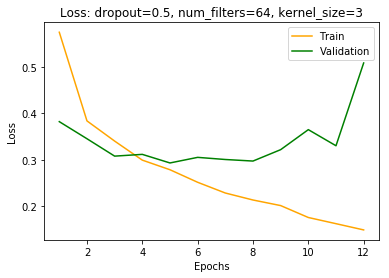

In [115]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: dropout={0}, num_filters={1}, kernel_size={2}'.format(dropout, num_filters, kernel_size))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

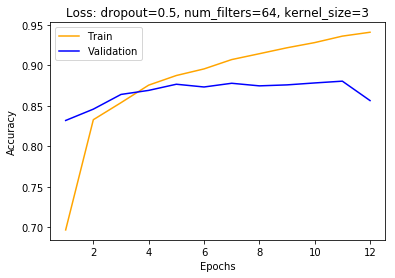

In [116]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Loss: dropout={0}, num_filters={1}, kernel_size={2}'.format(dropout, num_filters, kernel_size))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Prediction

In [117]:
y_test = cnn_simple_model.predict(x_test)

In [118]:
def to_binary(predict):
    return 1 if predict > 0.5 else 0

result = y_test.flatten()
result = [to_binary(predict) for predict in result]

In [119]:
output = pd.DataFrame(data = {"id": test['id'], "sentiment": result})

In [120]:
output.to_csv("Results/CNN_layer1_dropout0.5_kernel3_number.csv", index=False, quoting=3)

### Model Accuracy (Final Score)

In [121]:
#csv = pd.read_csv("Results/Bag_of_Words_model_feature3k_bigram.csv")

In [122]:
def classified_correct(model, i, inside=False):
    if inside:
        true_positive = model["sentiment"][i] == 0 and int(model["id"][i].split('"')[1].split("_")[1]) <= 5
        true_negative = model["sentiment"][i] == 1 and int(model["id"][i].split('"')[1].split("_")[1]) > 5
    
    else:
        true_positive = model["sentiment"][i] == 0 and int(model["id"][i].split("_")[1]) <= 5
        true_negative = model["sentiment"][i] == 1 and int(model["id"][i].split("_")[1]) > 5
    
    return true_positive or true_negative

target = output
correct = np.array([classified_correct(target, i, inside=True) for i in range(target.shape[0])])
print(correct.sum() / target.shape[0])

0.85384


In [112]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

y_true = test['score'].apply(lambda score: 1 if score > 5 else 0)
print("AUC score: %.5f" % roc_auc_score(y_true, result))

AUC score: 0.87800
